In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
%load_ext memory_profiler
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/home/sima9999/code/")
sys.path.append("/home/sima9999/git/pyOMA/")
from pathlib import Path


import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from examples.UQ_OMA import vars_definition, stage2mapping,stage3mapping, stage2n3mapping

import ray

from uncertainty.polymorphic_uncertainty import PolyUQ
from uncertainty.data_manager import DataManager

from model.acquisition import Acquire, sensor_position
from helpers import get_pcd

import pyOMA 

from pyOMA.core.PreProcessingTools import PreProcessSignals, GeometryProcessor, SignalPlot
from pyOMA.core.SSICovRef import BRSSICovRef, plot_corr_synth,show_channel_reconstruction
# from pyOMA.core.PLSCF_old import PLSCF as PLSCF_old
from pyOMA.core.PLSCF import PLSCF, plot_spec_synth
from pyOMA.core.SSIData import SSIDataMC, SSIDataCV, plot_sig_synth
from pyOMA.core.PostProcessingTools import MergePoSER
from pyOMA.core.PlotMSH import ModeShapePlot
from pyOMA.core.StabilDiagram import StabilCalc, StabilPlot
from pyOMA.GUI.JupyterGUI import StabilGUIWeb, PlotMSHWeb
from pyOMA.core.PostProcessingTools import pair_modes, compare_modes



import logging


%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas

## Reconstruction Error method


In [4]:

def load_measurements(fname, ftype='ascii', **kwargs):
    if ftype!='ascii':
        raise RuntimeError('Specified filetype: {} not implemented yet!'.format(ftype))
    
    with open(fname, 'rt') as f:

        '''for i in range(8):
            f.readline()
        start_time=f.readline().strip('\r\n\t').split(' ')[-2:]
        year,month,day=[int(a) for a in start_time[0].split('-')]
        hms,msecond=start_time[1].split('.')
        hour,minute,second=[int(a) for a in hms.split(':')]
        start_time=datetime.datetime(year,month,day,hour,minute,second,int(msecond))
        sample_rate = float(f.readline().strip('\n').split(' ')[-1].strip('\n')) 
        f.readline()        
        headers = f.readline().strip('\r\n\t').split('\t')
        units = f.readline().strip('\r\n\t').split('\t')
        units = [u.strip(' \t') for u in units]
        
        for i in range(12):
            f.readline()
        #min_=f.readline()
        #max_=f.readline()
        #mean=f.readline()
        #std=f.readline()
        #energ=f.readline()
        #f.readline()
        #f.readline()
        #f.readline()
        #f.readline()
        '''
        measurement = np.loadtxt(f)
        #measurement = measurement[0:12800,:]

    return measurement  

In [5]:
result_dir = Path('/home/sima9999/eclipse-workspace/2025_IOMAC/')
working_dir = Path('/dev/shm/womo1998/')

geometry_data = GeometryProcessor.load_geometry(
    nodes_file=result_dir / 'grid.txt',
    lines_file=result_dir / 'lines.txt',
    #parent_childs_file = working_dir / 'parent_childs'
    )

meas_file = result_dir / 'Messung_12' / 'Messung_12.asc'
                 
chan_dofs_file = result_dir / 'Messung_12' / 'channel_dofs'
this_result_folder = result_dir / 'Messung_12' 
conf_file = result_dir / 'Messung_12' / 'setup_info'

filter_freqs = (0.1, 1.5)
deci_factor = 3 # will be applied twice, resulting in 25 -> nyq = 2.048 Hz
num_block_rows = 210

PreProcessSignals.load_measurement_file = load_measurements

prep_signals = PreProcessSignals.init_from_config(conf_file, meas_file, chan_dofs_file)#, skiprows=40)

# prep_signals.correct_offset()
prep_signals.filter_signals(highpass=filter_freqs[0],lowpass=filter_freqs[1], overwrite=True)
# prep_signals.correct_offset()
prep_signals.decimate_signals(deci_factor)
prep_signals.decimate_signals(deci_factor)
# prep_signals.correct_offset()


### Example synthetization

In [4]:
# Warning! Computationally expensive, but needed for nice, smooth spectra :-)
m_lags = 2048
n_blocks = 1
prep_signals.corr_matrix_bt = None
# prep_signals.corr_blackman_tukey(m_lags, num_blocks=n_blocks, refs_only=True)
prep_signals.corr_welch(m_lags, n_segments=n_blocks, refs_only=True)

INFO:pyOMA.core.PreProcessingTools:Estimating PSD by Welch's method with 4094 frequency lines, 1 non-overlapping segments and a hamming window...
....................................................................................................
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Function by Welch's method with 2048 time lags and 1 non-overlapping segments.
....................................................................................................


array([[[ 9.67497453e-05,  9.36948731e-05,  8.50944815e-05, ...,
         -1.43473788e-05, -1.47174771e-05, -1.48526225e-05],
        [ 3.66883462e-05,  3.73351536e-05,  3.61424422e-05, ...,
         -8.03138628e-06, -8.12780275e-06, -8.02103023e-06],
        [ 3.15138534e-05,  3.14637238e-05,  3.06322049e-05, ...,
         -8.29236476e-06, -7.73197774e-06, -7.10748441e-06],
        [ 5.91969424e-05,  5.70751746e-05,  5.40529968e-05, ...,
         -1.65221460e-05, -1.65360291e-05, -1.63718842e-05]],

       [[ 3.66883462e-05,  3.40863940e-05,  2.97671869e-05, ...,
         -6.72468162e-06, -7.57658717e-06, -8.02103023e-06],
        [ 6.70247064e-05,  6.35653066e-05,  5.39168499e-05, ...,
          8.90515921e-07,  1.42678672e-06,  1.61753886e-06],
        [ 2.62848135e-05,  2.56663469e-05,  2.57359604e-05, ...,
         -5.09864849e-06, -5.30680824e-06, -5.28897973e-06],
        [ 2.69858012e-05,  2.51762886e-05,  2.34664827e-05, ...,
         -7.02242545e-06, -7.73106175e-06, -8.42265

DEBUG:pyOMA.core.PreProcessingTools:Arguments psd: n_lines=None, method=None, {'refs_only': True}
DEBUG:pyOMA.core.PreProcessingTools:Returning PSD by Welch's method with 4094 frequency lines, 1 non-overlapping segments and a hamming window...
DEBUG:pyOMA.core.PreProcessingTools:Arguments correlation: m_lags=2048, method=None, {'refs_only': True}
DEBUG:pyOMA.core.PreProcessingTools:Returning Correlation Function by Welch's method with 2048 time lags and 1 non-overlapping segments.
DEBUG:pyOMA.core.PreProcessingTools:Arguments correlation: m_lags=2048, method=None, {'refs_only': True}
DEBUG:pyOMA.core.PreProcessingTools:Returning Correlation Function by Welch's method with 2048 time lags and 1 non-overlapping segments.
DEBUG:pyOMA.core.PreProcessingTools:Arguments psd: n_lines=4094, method=None, {'refs_only': True}
DEBUG:pyOMA.core.PreProcessingTools:Returning PSD by Welch's method with 4094 frequency lines, 6 non-overlapping segments and a hamming window...
DEBUG:pyOMA.core.PreProcessi

(array([<AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,

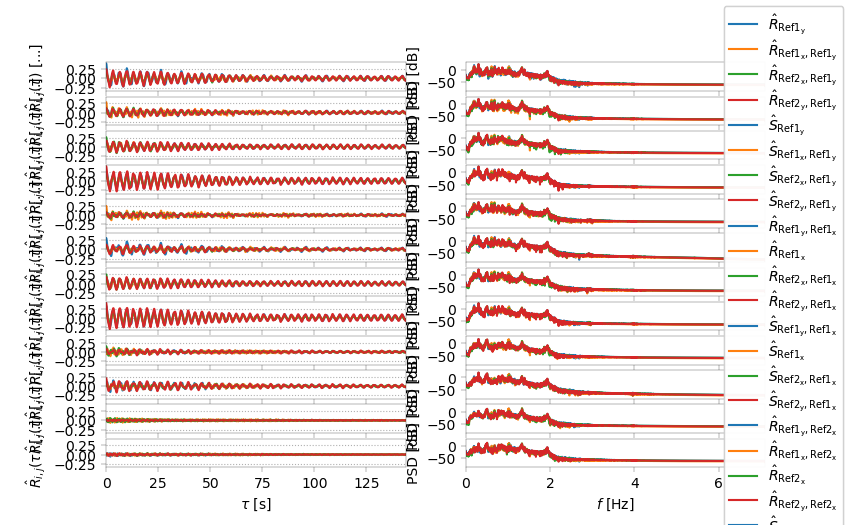

In [81]:
logger= logging.getLogger('pyOMA.core.PreProcessingTools')
logger.setLevel(level=logging.DEBUG)
sp = pyOMA.core.PreProcessingTools.SignalPlot(prep_signals)
sp.plot_signals(timescale='lags', psd_scale='db',per_channel_axes=True)
# logger.setLevel(level=logging.INFO)

#### SSICovRef

In [42]:
modal_data = BRSSICovRef(prep_signals)
modal_data.build_toeplitz_cov(prep_signals.m_lags // 2)

order=28
A, C, G = modal_data.estimate_state(order)
this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis(A, C)
_, this_modal_contributions = modal_data.synthesize_correlation(A, C, G)

INFO:pyOMA.core.SSICovRef:Assembling Toeplitz matrix using pre-computed correlation functions 1024 block-columns and 1025 block rows
DEBUG:pyOMA.core.PreProcessingTools:Arguments correlation: m_lags=2048, method=None, {}
DEBUG:pyOMA.core.PreProcessingTools:Returning Correlation Function by Welch's method with 2048 time lags and 1 non-overlapping segments.
INFO:pyOMA.core.SSICovRef:Decomposing Toeplitz matrix


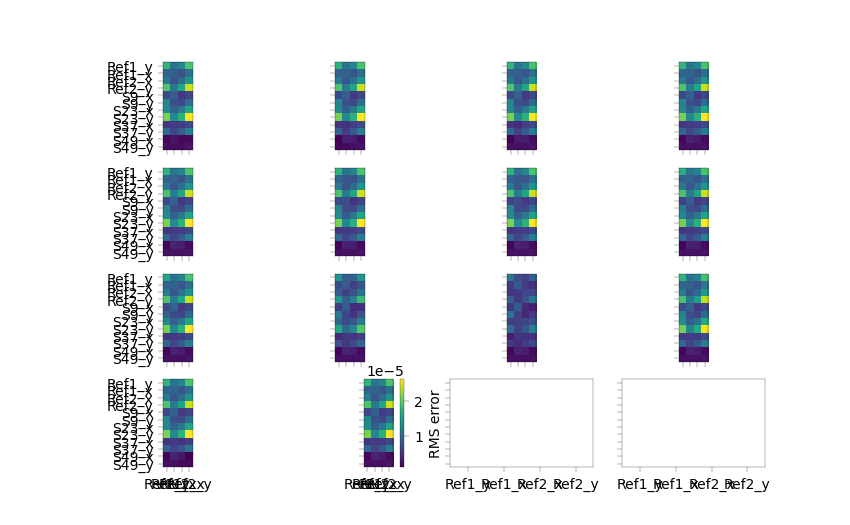

In [49]:
show_channel_reconstruction(modal_data)

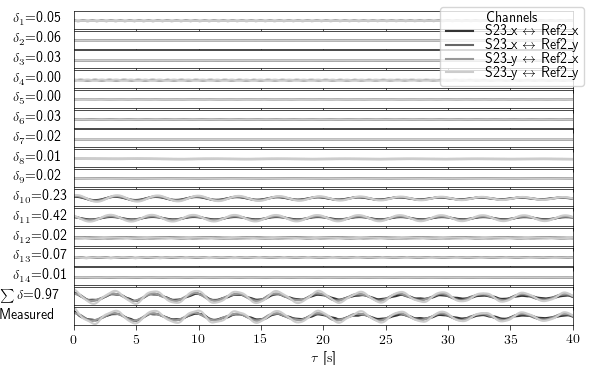

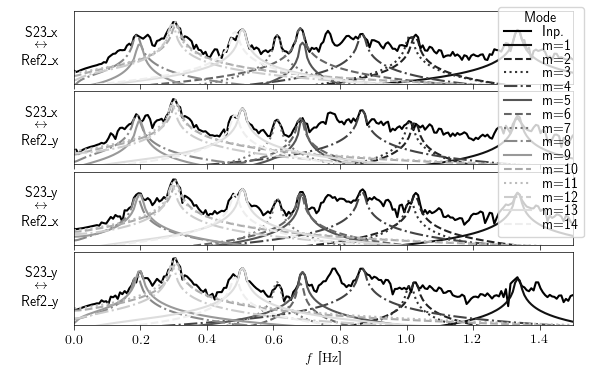

In [51]:
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")
from helpers import get_pcd
with matplotlib.rc_context(get_pcd('print')):  
    fig1, fig2 = plot_corr_synth(modal_data,
                                 modelist = np.where((this_modal_frequencies<1.5) & (this_modal_frequencies>0.0))[0],
                                 # modelist=[2,3,4,5,7,8,9,10],
                                 # modelist=[10,11,12,13,14,15,16], 
                                 # modelist=[0, 1, 2, 3, 4, 5], 
                                 # modelist=[6, 7, 8, 9,10,11], 
                                 channel_inds=[6,7], ref_channel_inds=[2,3])
    # fig1.axes[0].set_ylim((-.003,.003))
    fig1.axes[0].set_xlim((0, 40))
    
    fig2.axes[1].set_xlim((0, 1.5))
    # fig1.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/correlation_synthetization.png')
    # fig1.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/correlation_synthetization.pdf')
    # fig2.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/spectrum_synthetization.png')
    # fig2.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/spectrum_synthetization.pdf')

#### pLSCF

In [25]:
modal_data = PLSCF(prep_signals)
modal_data.build_half_spectra()

INFO:pyOMA.core.PLSCF:Constructing half-spectrum matrix ... 
DEBUG:pyOMA.core.PreProcessingTools:Arguments correlation: n_lags=2048, method=None, {}
DEBUG:pyOMA.core.PreProcessingTools:Returning Correlation Function by Welch's method with 2048 time lags and 12 non-overlapping segments.


In [26]:
alpha, beta_l_i = modal_data.estimate_model(35, False)
this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis_residuals(alpha, beta_l_i)
# this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis_state_space(alpha, beta_l_i)

half_spec_modal, modal_contributions = modal_data.synthesize_spectrum(alpha, beta_l_i, modal=True)
# half_spec_rmfd = modal_data.synthesize_spectrum(alpha, beta_l_i, modal=False)

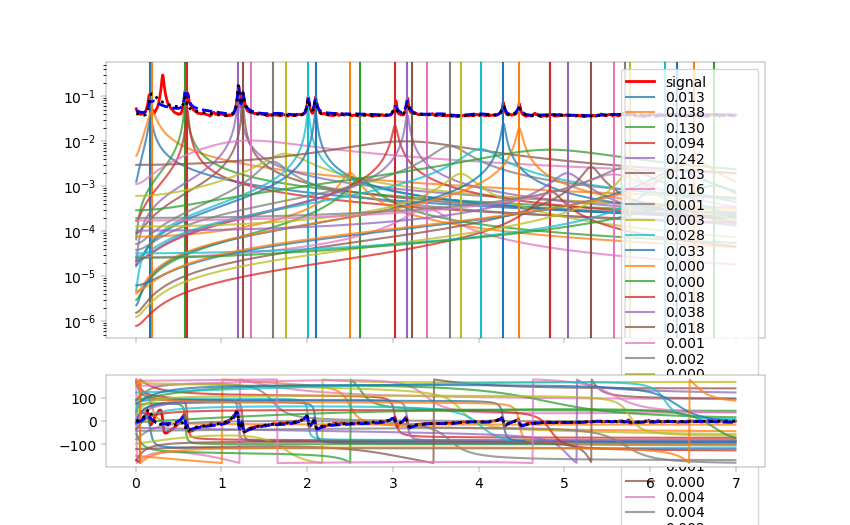

In [40]:
if True:
    num_modes = half_spec_modal.shape[-1]
    channel = 9
    ref_index = 1

    fig1,[ax1,ax2]=plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, sharex=True)

    ax1.plot(modal_data.selected_omega_vector/2/np.pi, np.abs(modal_data.pos_half_spectra[channel,ref_index,:]) , color='red', lw=2, label='signal') 
    ax2.plot(modal_data.selected_omega_vector/2/np.pi, np.angle(modal_data.pos_half_spectra[channel,ref_index,:], deg=True) , color='red', lw=2) 
    ax1.set_yscale('log')
    ylims = ax1.get_ylim()
    for mode in range(num_modes):
        line = ax1.plot(modal_data.selected_omega_vector/2/np.pi, np.abs(half_spec_modal[channel,ref_index,:,mode]), alpha=0.75, label=f'{np.abs(modal_contributions[mode]):1.3f}')
        ax2.plot(modal_data.selected_omega_vector/2/np.pi, np.angle(half_spec_modal[channel,ref_index,:,mode], deg=True), alpha=0.75) 
        ax1.axvline(this_modal_frequencies[mode], color=line[0].get_color())
    
    half_spec_synth = np.sum(half_spec_modal, axis=-1)
    half_spec_synth[:,:,:] += modal_data._lower_residuals[:,:,np.newaxis]
    half_spec_synth[:,:,:] += modal_data._upper_residuals[:,:,np.newaxis]*modal_data.selected_omega_vector[np.newaxis,np.newaxis,:]**2
    
    ax1.plot(modal_data.selected_omega_vector/2/np.pi, np.abs(half_spec_synth[channel,ref_index,:]) , color='blue', lw=2, ls='dashed', label=f'modal {np.abs(np.sum(modal_contributions)):1.3f}') 
    ax2.plot(modal_data.selected_omega_vector/2/np.pi, np.angle(half_spec_synth[channel,ref_index,:], deg=True) , color='blue', lw=2, ls='dashed') 
    modal_data.synthesize_spectrum(alpha, beta_l_i, modal=False)
    ax1.plot(modal_data.selected_omega_vector/2/np.pi, np.abs(modal_data._half_spec_synth[channel,ref_index,:]) , color='black', lw=2, ls='dotted', label='model') 
    ax2.plot(modal_data.selected_omega_vector/2/np.pi, np.angle(modal_data._half_spec_synth[channel,ref_index,:], deg=True) , color='black', lw=2, ls='dotted') 

    # ax1.set_ylim(ylims)
    # ax1.set_xlim((0,1.5))
    ax1.legend()

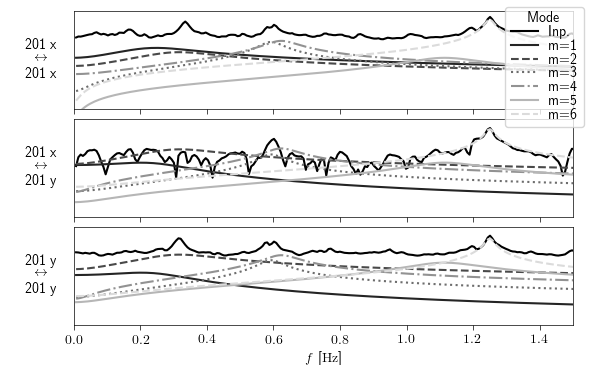

In [27]:
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")
from helpers import get_pcd
with matplotlib.rc_context(get_pcd('print')):  
    fig = plot_spec_synth(modal_data,
                    modelist = np.where((this_modal_frequencies<1.5) & (this_modal_frequencies>0.0))[0],
                    channel_inds=[8,9], ref_channel_inds=[0,1])

    fig.axes[1].set_xlim((0, 1.5))
    
    # fig.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/spectrum_synthetization_plscf.png')
    # fig.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/spectrum_synthetization_plscf.pdf')

#### SSIData

In [5]:
modal_data = SSIDataCV(prep_signals)
num_training_blocks = 1
modal_data.build_block_hankel(prep_signals.m_lags // 2, num_blocks=n_blocks, training_blocks=np.random.choice(np.arange(n_blocks),num_training_blocks, False))

INFO:pyOMA.core.SSIData:Building Block-Hankel matrix from  1 out of 1 signal blocks with 1024 block-columns and 1024 block rows.
....................................................................................................
INFO:pyOMA.core.SSIData:Estimating subspace matrix...


In [6]:
A,C,Q,R,S = modal_data.estimate_state(30)
validation_blocks = np.arange(n_blocks)
# validation_blocks = np.array([4,5,6])
this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis(A, C)
all_sig_synth, modal_contributions = modal_data.synthesize_signals( A, C, Q, R, S, validation_blocks)


INFO:pyOMA.core.SSIData:Block '0' is in the validation dataset, but only has 2048 startup-samples (recommended/chosen: 4710) from any previous block for the Kalman Filter. Expect a degraded performance.


In [167]:
if False:
    n_validation_blocks = validation_blocks.shape[0]
    num_blocks = modal_data.num_blocks
    total_time_steps = prep_signals.total_time_steps
    q = modal_data.num_block_rows
    p = modal_data.num_block_rows
    N_b = int(np.floor((total_time_steps - q - p) / num_blocks))
    N = N_b * num_blocks
    N_0_offset = total_time_steps - q - p - N
    N_offset = N_b // 15
    block_starts = validation_blocks*N_b + N_0_offset + p + q
    block_starts + N_b + q + p

    channel = 8

    plt.figure()
    t = prep_signals.t
    plt.plot(t, sig[:, channel], c='grey')
    ax = plt.gca()
    fig,axes = plt.subplots(5,2, sharex=True)
    axes = axes.flat
    for i in range(n_validation_blocks):
        sig_synth = all_sig_synth[i]

        ax.plot(t[block_starts[i]:block_starts[i]+N_b],np.sum(sig_synth[channel,:,:] ,axis=-1), alpha=0.5)

        for mode in range(10):

            axes[mode].plot(t[block_starts[i]:block_starts[i]+N_b],sig_synth[channel,:,mode], alpha=0.5)

In [71]:
display(list(enumerate(this_modal_frequencies)))
[0,1,4,5,11,12,13,14]
modal_contributions

[(0, 0.19536034237641073),
 (1, 0.1968484743073187),
 (2, 0.2974989203289832),
 (3, 0.30219649340924243),
 (4, 0.4772359009695678),
 (5, 0.5080141705107716),
 (6, 0.6109491498735209),
 (7, 0.6159116543869089),
 (8, 0.6825766975096325),
 (9, 0.6901206662287462),
 (10, 0.7631094072255821),
 (11, 1.0090284648891756),
 (12, 1.0375572913503284),
 (13, 1.3268963025405798),
 (14, 1.3360301407203834),
 (15, nan),
 (16, nan),
 (17, nan),
 (18, nan),
 (19, nan),
 (20, nan),
 (21, nan),
 (22, nan),
 (23, nan),
 (24, nan),
 (25, nan),
 (26, nan),
 (27, nan),
 (28, nan),
 (29, nan)]

array([0.04443787, 0.06705387, 0.04609306, 0.05000631, 0.03291958,
       0.02435705, 0.02261378, 0.09566376, 0.02242605, 0.04770337,
       0.05680391, 0.07080585, 0.04264965, 0.1515481 , 0.11005217,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

KeyboardInterrupt: 

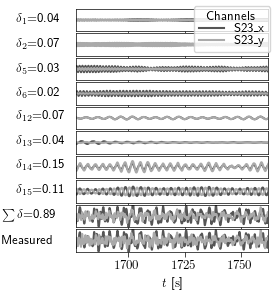

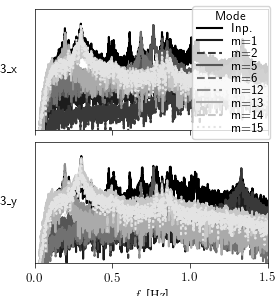

In [12]:
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")

with matplotlib.rc_context(get_pcd('beamer_half')):  
    fig1, fig2 = plot_sig_synth(modal_data,
                        modelist = [0,1,4,5,11,12,13,14],#np.where((this_modal_frequencies<1.5) & (this_modal_frequencies>0.0))[0],
                        channel_inds=[6,7],i_block=0)
    fig1.get_axes()[0].set_xlim((875,1050))
    fig1.get_axes()[0].set_ylim((-0.045,0.045))
    fig2.get_axes()[0].set_xlim((0,1.5))
    fig2.get_axes()[0].set_ylim(ymin=-40)
    fig2.subplots_adjust(left=None, bottom=None, right=0.97, top=0.97, wspace=None, hspace=0.1,)
    fig1.subplots_adjust(left=None, bottom=None, right=0.97, top=0.97, wspace=None, hspace=0.1,)
    fig1.subplots_adjust(bottom=0.15,left=0.275)
    for i in range(1400):
        fig1.axes[0].set_xlim((875+i, 960+i))
        fig1.savefig(f'/home/sima9999/2019_OMA_UQ/pres/figures/oma/schwabach_signal_synthetization_{i}.png')
        fig1.savefig(f'/home/sima9999/2019_OMA_UQ/pres/figures/oma/schwabach_signal_synthetization_{i}.pdf')
    # fig1.savefig(f'/home/sima9999/eclipse-workspace/2025_IOMAC/schwabach_signal_synthetization.png')
    # fig1.savefig(f'/home/sima9999/eclipse-workspace/2025_IOMAC/schwabach_signal_synthetization.pdf')
    # fig2.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/signal_synthetization_spectrum.png')
    # fig2.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/signal_synthetization_spectrum.pdf')

### Example: Reconstruction Error

The model error with a given parameter set (m_lags, model_order) is sought for by separating the input data into a number of blocks. The sum of modal reconstruction errors is computed on each block model and averaged. This measure can be used to judge on the suitability of the chosen parameter set. However, it is suspectible to overfit. 

How do we penalize overfit?
Overfitted models generally produce almost perfect reconstruction, but achieve that at the cost of many (noise) modes, splitted modes, etc. The number of modes increases, i.e. the "number of directions in the parameter space that are unimportant for prediction" are large. A trade-off between model order and prediction has to be made. This is easily visible in a full-factorial setting or can be found by optimization, but it is not suitable as a UQ criterion, because overfit models would generally perform best.

Wen want the prediction be concentrated to as few modes as possible, i.e. the mean value should be largest? No, because this gives best results at lowest orders.

Additional problem, when modesplitting occurs, one member of the pair may have very high modal contributions, while the other member compensates this with a negative contribution

Its  not known beforehand, how much of the signal can be reconstructed. The question is, how many modes do we need to construct as much of the physical signal (not the noise content) as possible?  An approach would be to segment the sequence of modal contributions of a single model into the modes with high MC and the noise modes. A first approach was to find local minima in estimated kernel densities as the segmentation points. This frequently rejects too many modes (all). A second approach was to find the largest gap in modal contributions (argmax of differences of sorted mcs). That also does not lead to satisfactory results. We seem to have reached a dead-end, where others have failed before and why OMA is generally hard to automate.

We also cannot reject a fixed or a relative number of modes, because we do not know how many physical modes are observable in the signal. Because, ideally, if there is no noise and the right model order is chosen, all modes contribute to the physical signal.


Show a full-factorial example over a range of m_lags and model_orders. Additionally perform a convergence study over the number of blocks.

In [72]:
n_blocks = 40

k = 10


max_model_order = 40
max_m_lags = 200
n_orders = 37
n_m_lags = 37

orders = np.linspace(max_model_order/10,max_model_order,n_orders, dtype=int)
all_lags = np.linspace(max_m_lags/10,max_m_lags,n_m_lags, dtype=int)

prep_signals.corr_blackman_tukey(max_m_lags, num_blocks=n_blocks, refs_only=True)
pass

DEBUG:pyOMA.core.PreProcessingTools:Not returning because: self.corr_matrix_bt not available
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with m_lags=200 and num_blocks=40...
....................................................................................................


In [74]:
rng = np.random.default_rng(123456789)

cardinality = n_blocks // k
block_indices = np.arange(cardinality*k)
rng.shuffle(block_indices)
block_indices, cardinality


(array([ 4, 16,  3, 21, 10, 27,  5, 29, 15, 36,  7, 33, 34, 31, 20,  8, 35,
        22, 39, 32, 26,  2, 23, 25,  9, 38, 11,  1,  0, 14, 37, 24, 30, 19,
        18, 17,  6, 12, 13, 28]),
 4)

In [75]:
i=9
test_set = block_indices[i * cardinality:(i + 1) * cardinality]
training_set = np.take(block_indices, np.arange((i + 1) * cardinality, (i + k) * cardinality), mode='wrap')
display(test_set, training_set)

array([ 6, 12, 13, 28])

array([ 4, 16,  3, 21, 10, 27,  5, 29, 15, 36,  7, 33, 34, 31, 20,  8, 35,
       22, 39, 32, 26,  2, 23, 25,  9, 38, 11,  1,  0, 14, 37, 24, 30, 19,
       18, 17])

In [76]:
meth_ind = 2
method = ['ssicovref', 'plscf', 'ssidata' ][meth_ind]
res_fname = result_dir / ['example_reconstruction_validation.npy', 'example_reconstruction_validation_plscf.npy', 'example_reconstruction_validation_ssidata.npy'][meth_ind]

if os.path.exists(res_fname) and True:
    all_modal_contributions = np.load(res_fname)
else:
    if meth_ind == 0:
        modal_data = BRSSICovRef(prep_signals)
    elif meth_ind == 1:
        modal_data = PLSCF(prep_signals)
    elif meth_ind == 2:
        modal_data = SSIDataCV(prep_signals)
    
    model_performance = np.zeros((n_m_lags, n_orders))
    performance_deviation = np.zeros((n_m_lags, n_orders))
    all_modal_contributions = np.full((n_m_lags, n_orders, k, max_model_order), np.nan)

    for i_m_lags in range(n_m_lags):
        this_m_lags = all_lags[i_m_lags]
        print(this_m_lags//2)
        for i in range(k):

            test_set = block_indices[i * cardinality:(i + 1) * cardinality]
            training_set = np.take(block_indices, np.arange((i + 1) * cardinality, (i + k) * cardinality), mode='wrap')
            
            if meth_ind != 2:
                prep_signals.corr_matrix_bt = np.mean(prep_signals.corr_matrices_bt[training_set,...,:this_m_lags], axis=0)
                prep_signals.n_lines_bt = (this_m_lags - 1) * 2
            
            if meth_ind == 0:
                modal_data.build_toeplitz_cov(int(this_m_lags // 2))
            elif meth_ind == 1:
                modal_data.build_half_spectra(int(this_m_lags),-1,100)
            elif meth_ind == 2:
                modal_data.build_block_hankel(num_block_rows=int(this_m_lags) // 2, num_blocks=n_blocks, training_blocks=training_set)
            
            if meth_ind != 2:
                prep_signals.corr_matrix_bt = np.mean(prep_signals.corr_matrices_bt[test_set,...,:this_m_lags], axis=0)
            
            for i_order in range(n_orders):
                order = orders[i_order]
                
                if modal_data.max_model_order is not None and order>modal_data.max_model_order: continue
                
                if meth_ind == 0:
                    A, C, G = modal_data.estimate_state(order)
                    this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis(A, C)
                    _, this_modal_contributions = modal_data.synthesize_correlation(A, C, G)
                elif meth_ind == 1:
                    alpha, beta_l_i = modal_data.estimate_model(order, False)
                    this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis_residuals(alpha, beta_l_i)
                    _, this_modal_contributions = modal_data.synthesize_spectrum(alpha, beta_l_i, modal=True)
                if meth_ind == 2:
                    A,C,Q,R,S = modal_data.estimate_state(order)
                    this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis(A, C)
                    _, this_modal_contributions = modal_data.synthesize_signals( A, C, Q, R, S, test_set)
                    
                # _, _, _, _, this_modal_contributions = modal_data.single_order_modal(order, synth_corr=True)
                nonzero = this_modal_contributions != 0
                all_modal_contributions[i_m_lags,i_order, i, :np.sum(nonzero)] = this_modal_contributions[nonzero]
    
    np.save(res_fname, all_modal_contributions)
    
    logger.setLevel(level=logging.INFO)


INFO:pyOMA.core.SSIData:Building Block-Hankel matrix from  36 out of 40 signal blocks with 45 block-columns and 45 block rows.
....................................................................................................
INFO:pyOMA.core.SSIData:Estimating subspace matrix...
INFO:pyOMA.core.SSIData:Building Block-Hankel matrix from  36 out of 40 signal blocks with 45 block-columns and 45 block rows.
....................................................................................................
INFO:pyOMA.core.SSIData:Estimating subspace matrix...
INFO:pyOMA.core.SSIData:Building Block-Hankel matrix from  36 out of 40 signal blocks with 45 block-columns and 45 block rows.
....................................................................................................
INFO:pyOMA.core.SSIData:Estimating subspace matrix...
INFO:pyOMA.core.SSIData:Building Block-Hankel matrix from  36 out of 40 signal blocks with 45 block-columns and 45 block rows.
...........................

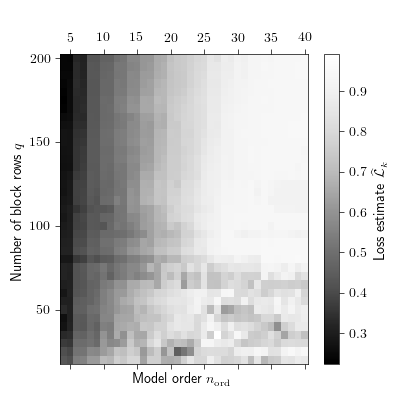

In [88]:
all_modal_contributions2 = np.copy(all_modal_contributions)
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")
#reject noise modes but keep out-of-phase split mode (=negative mc) to counteract high mc of corresponding in-phase mode

if False:
    for i_m_lags in range(n_m_lags):
        for i_order in range(n_orders):

            this_modal_contributions = all_modal_contributions2[i_m_lags, i_order,:,:]
            this_modal_contributions = this_modal_contributions[~np.isnan(this_modal_contributions)]
            this_modal_contributions = np.abs(np.sort(this_modal_contributions))

            if this_modal_contributions.shape[0]<2:continue
            argmax = np.argmax(np.diff(this_modal_contributions))
            thresh = this_modal_contributions[argmax]
            
            this_modal_contributions = all_modal_contributions2[i_m_lags, i_order,:,:]
            indexer = this_modal_contributions**2 <= thresh**2
            all_modal_contributions2[i_m_lags, i_order,  indexer] = np.nan
else:        
    all_negative_contributions = np.copy(all_modal_contributions2)
    all_negative_contributions[all_negative_contributions>=0.0] = np.nan
    all_modal_contributions2[all_modal_contributions2 <=0.0] = np.nan
    pass

#sum over modes, mean over validation sets
model_performance2 = np.nanmean(np.nansum(all_modal_contributions2, axis=3), axis=2)
model_performance3 = np.nanmean(np.nansum(all_negative_contributions, axis=3), axis=2)

model_performance2[model_performance2==0] = np.nan

orderstep = orders[1]-orders[0]
lagstep = all_lags[1]-all_lags[0]

with matplotlib.rc_context(get_pcd('print')):  
    mappable = plt.matshow(model_performance2+model_performance3, 
                           # vmin=0, vmax=1,
                           cmap='Greys_r', 
                extent=[orders[0]-orderstep/2, orders[-1]+orderstep/2,all_lags[0]-lagstep/2, all_lags[-1]+lagstep/2], 
                # extent=[orders[0]-orderstep/2, orders[-1]+orderstep/2,(all_lags[0]-lagstep/2)*2-1, (all_lags[-1]+lagstep/2)*2-1], 
                aspect='auto', origin='lower',
                          interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label('Loss estimate $\widehat{\mathcal{L}}_k$')
    argmax = np.where(np.isnan(model_performance2).T)
    plt.scatter( orders[argmax[0]], all_lags[argmax[1]], marker='+', color='k', s=20)
    # argmax =  np.where(model_performance2.T==model_performance2.max())
    # plt.scatter( orders[argmax[0]], all_lags[argmax[1]], marker='+', color='blue')
    plt.xlabel('Model order $n_\mathrm{ord}$')
    if meth_ind==0:
        plt.ylabel('Number of lags $M$')
    if meth_ind==1:
        plt.ylabel('Number of frequency lines $M$')
    if meth_ind==2:
        plt.ylabel('Number of block rows $q$')
        
    # if meth_ind==0:
    #     plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error.png')
    #     plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error.pdf')
    # elif meth_ind==1:
    #     plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error_plscf.png')
    #     plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error_plsf.pdf')
    # elif meth_ind==2:
    if meth_ind==2:
        plt.savefig(f'/home/sima9999/eclipse-workspace/2025_IOMAC/schwabach_reconstruction_error_ssidata.png')
        plt.savefig(f'/home/sima9999/eclipse-workspace/2025_IOMAC/schwabach_reconstruction_error_ssidata.pdf')

    

# mappable = plt.matshow(model_performance3, 
#                        # vmin=0.01, vmax=1,
#                        cmap='Greys_r', 
#             extent=[orders[0]-orderstep/2, orders[-1]+orderstep/2,all_lags[0]-lagstep/2, all_lags[-1]+lagstep/2], 
#             aspect='auto', origin='lower')
# cbar = plt.colorbar()
# cbar.set_label('Percentage Negative Reconstruction')
# plt.xlabel('Model order')
# plt.ylabel('Number of lags')

# plt.matshow(performance_deviation, cmap='Greys_r', extent=[int(max_model_order/10), max_model_order, int(max_m_lags/10),max_m_lags, ], aspect='auto', origin='lower')
# plt.xlabel('Model order')
# plt.ylabel('Number of lags')
# plt.imshow()

In [ ]:
pd_kwargs

In [24]:
n_blocks = 40
m_lags = 339
order = 100

logger= logging.getLogger('pyOMA.core.PreProcessingTools')
logger.setLevel(level=logging.INFO)

# prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs, ref_channels=[8,9])
# prep_signals.add_chan_dofs(chan_dofs)
# prep_signals.decimate_signals(4)
prep_signals.corr_blackman_tukey(m_lags, num_blocks=n_blocks, refs_only=True)
prep_signals.sv_psd()
pass

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with m_lags=339 and num_blocks=40...
INFO:pyOMA.core.PreProcessingTools:Estimating Power Spectral Density by Blackman-Tukey's method...


## Mapping

In [45]:
modules = ['pyOMA.core.Helpers','pyOMA.core.PreProcessingTools','pyOMA.core.SSICovRef','pyOMA.core.SSIData','pyOMA.core.PLSCF','model.mechanical','model.acquisition']
for module in modules:
    logger_ = logging.getLogger(module)
    logger_.setLevel(logging.WARNING)

In [7]:
from model.mechanical import Mechanical, MechanicalDummy
from model.acquisition import Acquire, sensor_position

from pyOMA.core.PreProcessingTools import PreProcessSignals
from pyOMA.core.SSICovRef import BRSSICovRef

In [8]:
n_locations = 5
DTC = 16
sensitivity_nominal = 1.02
sensitivity_deviation_percent = 2
spectral_noise_slope = -0.55
sensor_noise_rms = 1e-3

result_dir = Path('/scratch/sima9999/2019_IOMAC/')
this_result_dir  = result_dir
working_dir = Path(working_dir)

seed = 123456789


# num_nodes = mech.num_nodes
num_nodes = 203

setups = sensor_position(n_locations, num_nodes, 'distributed')
# select a setup based on a "random" integer modulo the total number of setups
i_setup = seed % setups.shape[0]
sensor_nodes = setups[i_setup,:]
quant = 'a'
quant = ['d', 'v', 'a'].index(quant)
# list of (node, dof, quant)
channel_defs = []
for node in sensor_nodes:
    # We work around the Hack from transient_ifrf, where we omitted the x-axis in the response,
    # by wrongly definining dofs ux and uy instead of uy and uz

    for dof in ['ux','uy']:
        dof = ['ux', 'uy', 'uz'].index(dof)
        channel_defs.append((node, dof, quant))


mech = MechanicalDummy.load(fpath=result_dir / 'mechanical.npz')
arr = np.load(this_result_dir / 'response.npz')

# Here's the Hack
mech.t_vals_amb = arr['t_vals']
mech.resp_hist_amb = [arr['d_freq_time'], arr['v_freq_time'], arr['a_freq_time']]
mech.deltat = mech.t_vals_amb[1] - mech.t_vals_amb[0]
mech.timesteps = mech.t_vals_amb.shape[0]
mech.state[2] = True


# the above hack conflicts with the modeshape dof though, 
# so we have to hack around it as well
mech.damped_mode_shapes = np.delete(mech.damped_mode_shapes, (0), axis=1)

acqui = Acquire.init_from_mech(mech, channel_defs)

sensitivity_deviation = sensitivity_deviation_percent / 100 * sensitivity_nominal
acqui.apply_sensor(DTC=DTC, 
                     sensitivity_nominal=sensitivity_nominal, sensitivity_deviation=sensitivity_deviation, 
                     spectral_noise_slope=spectral_noise_slope, noise_rms=sensor_noise_rms, 
                     seed=seed)

acqui.save(this_result_dir / 'measurement.npz', differential='sensed')

In [51]:
def iomac_verify_mapping(decimation_factor, duration,
                    jid, result_dir, working_dir, skip_existing=False, **kwargs):
    
    
    range_estimation_duration = 300
    range_estimation_margin = 10
    DAQ_noise_rms = 1e-3
    anti_aliasing_cutoff_factor = 0.45
    quant_bit_factor = 6
    
    acqui = Acquire.load(result_dir / 'measurement.npz', differential='sensed')
    
    meas_range = 3#acqui.estimate_meas_range(sample_dur=range_estimation_duration, margin=range_estimation_margin,seed=seed)
    
    quantization_bits = quant_bit_factor * 4
    anti_aliasing_cutoff = anti_aliasing_cutoff_factor * acqui.sampling_rate / decimation_factor
    acqui.sample(dec_fact=decimation_factor, aa_cutoff=anti_aliasing_cutoff, 
                   bits=quantization_bits, meas_range=meas_range, 
                   duration=None)
    # add noise here, because sampling (decimation) removes all noise again

    acqui.add_noise(noise_power=DAQ_noise_rms**2, seed=seed)
    N = int(duration // acqui.deltat)
    acqui.signal_samp = acqui.signal_samp[:,-N:]
    acqui.t_vals_samp = acqui.t_vals_samp[:N]
    
    
    tau_max = 8 #seconds, corresponds to m=112 @ fs=14 Hz
    model_order = 28
    f_s = 70 / decimation_factor
    # tau_max = m_lags / f_s
    m_lags = int(np.floor(tau_max * f_s))
    estimator =  ['blackman-tukey','welch'][0]
    n_blocks=40
    k = 10
    
    pd_kwargs = acqui.to_prep_data()
    ref_channels=np.where(acqui.channel_defs[:,0]==201)[0]

           
    prep_signals = PreProcessSignals(**pd_kwargs, ref_channels=ref_channels)
    # prep_signals.corr_blackman_tukey(m_lags, num_blocks=n_blocks, refs_only=True)
    if estimator == 'blackman-tukey':
        prep_signals.corr_blackman_tukey(m_lags, num_blocks=n_blocks)
    elif estimator == 'welch':
        prep_signals.corr_welch(m_lags, n_segments=n_blocks)
        
        
    
    rng = np.random.default_rng(seed)
    cardinality = n_blocks // k
    block_indices = np.arange(cardinality*k)
    rng.shuffle(block_indices)
    
    
    sums_mc = []
    # holdout method, single run with a training and test set 
    for i in range(k):
        if k == 1:
            test_set = block_indices
            training_set = block_indices
        else:
            test_set = block_indices[i * cardinality:(i + 1) * cardinality]
            training_set = np.take(block_indices, np.arange((i + 1) * cardinality, (i + k) * cardinality), mode='wrap')    
        # print(test_set)

        if estimator == 'blackman-tukey':
            training_corr = np.mean(prep_signals.corr_matrices_bt[training_set,...], axis=0)
            test_corr = np.mean(prep_signals.corr_matrices_bt[test_set,...], axis=0)    
        elif estimator == 'welch':
            training_corr = np.mean(prep_signals.corr_matrices_wl[training_set,...], axis=0)
            test_corr = np.mean(prep_signals.corr_matrices_wl[test_set,...], axis=0)    


        ssi_cov_ref = BRSSICovRef(prep_signals)

        if estimator == 'blackman-tukey':
            prep_signals.corr_matrix_bt = training_corr
        elif estimator == 'welch':
            prep_signals.corr_matrix_wl = training_corr

        ssi_cov_ref.build_toeplitz_cov() # expensive, should be saved

        if estimator == 'blackman-tukey':
            prep_signals.corr_matrix_bt = test_corr
        elif estimator == 'welch':
            prep_signals.corr_matrix_wl = test_corr

        A_sc, C_sc, G_sc = ssi_cov_ref.estimate_state(model_order)
        f_sc, d_sc, phi_sc, lamda_sc = ssi_cov_ref.modal_analysis(A_sc, C_sc)
        _, mc_sc = ssi_cov_ref.synthesize_correlation(A_sc, C_sc, G_sc)  # expensive, last step in analysis: does not have to be saved
        sums_mc.append(np.sum(mc_sc))
    
    return sums_mc
            

iomac_verify_mapping(20,30*60, 'test', result_dir, working_dir)

[0.7177968809262922,
 0.7923094904805744,
 0.6247647441617127,
 0.8304272183475381,
 0.741298047659349,
 0.6840716534768805,
 0.741264677365037,
 0.7833013566181785,
 0.7145384462788603,
 0.8930014775938334]

In [ ]:
decimation_factor = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] # corresponds to fs = 70.00,35.00,23.33,17.50,14.00,11.67,10.00,8.75,7.78,7.00,6.36,5.83,5.38,5.00,4.67,4.38,4.12,3.89
duration = [10,16.5,23,29.5,36,42.5,49,55.5,62,68.5,75,81.5,88,94.5,101,107.5,114,120.5] # in minutes
n_dec_facts = len(decimation_factor)
n_dur = len(duration)
k = 10

res_fname = result_dir / 'example_reconstruction_verification.npy'

if os.path.exists(res_fname) and False:
    all_modal_contributions = np.load(res_fname)
else:
    all_modal_contributions = np.full((n_dec_facts, n_dur, k), np.nan)

    for i_dec in range(n_dec_facts):
        this_dec_fact = decimation_factor[i_dec]
        
        for i_dur in range(n_dur):
            print(i_dec,i_dur)
            this_duration = duration[i_dur]
            
           
            this_modal_contributions = iomac_verify_mapping(this_dec_fact,this_duration * 60, 'test', result_dir, working_dir)

            all_modal_contributions[i_dec, i_dur, :] = this_modal_contributions
    
    np.save(res_fname, all_modal_contributions)


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9


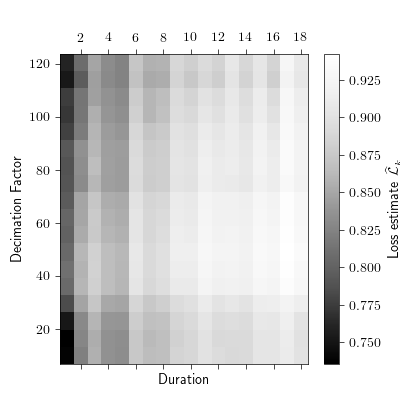

In [50]:
decisetp = decimation_factor[1]-decimation_factor[0]
dur_step = duration[1]-duration[0]

with matplotlib.rc_context(get_pcd('print')):  
    mappable = plt.matshow(np.mean(all_modal_contributions, axis=2), 
                           # vmin=0, vmax=1,
                           cmap='Greys_r', 
                extent=[decimation_factor[0]-decisetp/2, decimation_factor[-1]+decisetp/2,duration[0]-dur_step/2, duration[-1]+dur_step/2], 
                # extent=[decimation_factor[0]-decisetp/2, decimation_factor[-1]+decisetp/2,(duration[0]-dur_step/2)*2-1, (duration[-1]+dur_step/2)*2-1], 
                aspect='auto', origin='lower',
                          interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label('Loss estimate $\widehat{\mathcal{L}}_k$')
    # argmax = np.where(np.isnan(model_performance2).T)
    # plt.scatter( decimation_factor[argmax[0]], duration[argmax[1]], marker='+', color='k', s=20)
    # argmax =  np.where(model_performance2.T==model_performance2.max())
    # plt.scatter( decimation_factor[argmax[0]], duration[argmax[1]], marker='+', color='blue')
    plt.xlabel('Duration')
    
    plt.ylabel('Decimation Factor')

## Interactive correlation computation

In [55]:
import time
from IPython.display import clear_output
from matplotlib import animation
prep_signals.signals.shape

m_lags = 350
num_blocks = 10
prep_signals.corr_blackman_tukey(1000,num_blocks)

array([[[ 3.42204168e-04,  3.26675113e-04,  2.83520352e-04, ...,
          3.04689899e-05,  2.98090483e-05,  2.29356309e-05],
        [ 1.35066456e-04,  1.26394591e-04,  1.13338032e-04, ...,
         -2.78514379e-06,  1.29379051e-05,  2.52022619e-05],
        [ 6.57931764e-05,  6.23819061e-05,  5.63092863e-05, ...,
         -1.62071399e-05, -2.14006658e-05, -2.64893874e-05],
        [ 1.36137287e-04,  1.43567849e-04,  1.54894090e-04, ...,
          1.34020942e-05,  1.59228134e-05,  2.29730128e-05]],

       [[ 1.35066456e-04,  1.38285228e-04,  1.35380913e-04, ...,
         -5.43481467e-06,  1.17514043e-05,  2.85925748e-05],
        [ 4.76181680e-04,  4.59297539e-04,  4.11339487e-04, ...,
          9.40789459e-05,  1.45158219e-04,  1.86355820e-04],
        [ 1.81578009e-04,  1.86519889e-04,  1.90143044e-04, ...,
          2.65871881e-05,  3.59872770e-05,  4.38881903e-05],
        [ 4.37451663e-05,  4.65340934e-05,  4.72031390e-05, ...,
         -1.61957845e-05, -1.71166128e-05, -1.92310

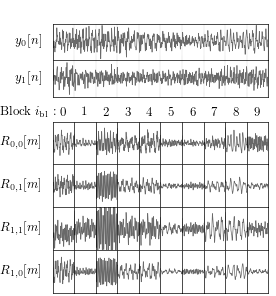

In [171]:
with matplotlib.rc_context(get_pcd('beamer_half')):  
    i_r = 0
    i_l = 1

    cutoff = prep_signals.signals.shape[0] - 10*m_lags - 1
    blocks = np.linspace(0,prep_signals.signals.shape[0]-cutoff-m_lags,num=num_blocks+1)

    # First set up the figure, the axis, and the plot element we want to animate
    # fig, (ax1,ax2) = plt.subplots(3,1, sharex=True, sharey=True)

    fig = plt.figure()
    gs = fig.add_gridspec(6, 1, hspace=1)
    gs0 = gs[0:2].subgridspec(2,1, hspace=0)
    gs1 = gs[2:6].subgridspec(4,num_blocks, wspace=0, hspace=0 )

    ax1 = fig.add_subplot(gs0[0,:])
    ax2 = fig.add_subplot(gs0[1,:], sharex=ax1, sharey=ax1)
    axes1 = [fig.add_subplot(gs1[0,0]),]
    for i in range(1,num_blocks):
        axes1.append(fig.add_subplot(gs1[0,i],sharex=axes[0], sharey=axes[0]))
    axes2 = [fig.add_subplot(gs1[1,0]),]
    for i in range(1,num_blocks):
        axes2.append(fig.add_subplot(gs1[1,i],sharex=axes[0], sharey=axes[0]))

    axes3 = [fig.add_subplot(gs1[2,0]),]
    for i in range(1,num_blocks):
        axes3.append(fig.add_subplot(gs1[2,i],sharex=axes[0], sharey=axes[0]))

    axes4 = [fig.add_subplot(gs1[3,0]),]
    for i in range(1,num_blocks):
        axes4.append(fig.add_subplot(gs1[3,i],sharex=axes[0], sharey=axes[0]))

    ax1.plot(prep_signals.signals[:-cutoff-m_lags, i_r], color='dimgrey', lw=0.5)
    line, = ax2.plot(prep_signals.signals[:-cutoff-m_lags, i_l], color='dimgrey', lw=0.5)

    for t in blocks:
        ax1.axvline(t, lw=0.25, color='grey', ls='dotted')
    lines = []
    for t in blocks:
        lines.append(ax2.axvline(t, lw=0.25, color='grey', ls='dotted'))

    corrs1 = []
    for j, ax in enumerate(axes1):
        corrs1.append(ax.plot(prep_signals.corr_matrices_bt[j, i_r, i_r,:], color='dimgrey', lw=0.5)[0])
        ax.xaxis.set_label_position('top') 
        ax.set_xlabel(f'${j}$')
        ax.set_yticks([],[])
        ax.set_xticks([],[])
        ax.set_xlim((0,m_lags-10))
    corrs2 = []
    for j, ax in enumerate(axes2):
        corrs2.append(ax.plot(prep_signals.corr_matrices_bt[j, i_r, i_l,:], color='dimgrey', lw=0.5)[0])
        # ax.set_xlabel(f'$i_{{bl}}={j},$')
        ax.set_yticks([],[])
        ax.set_xticks([],[])
        ax.set_xlim((0,m_lags-10))
    corrs3 = []
    for j, ax in enumerate(axes3):
        corrs3.append(ax.plot(prep_signals.corr_matrices_bt[j, i_l, i_l,:], color='dimgrey', lw=0.5)[0])
        # ax.set_xlabel(f'$i_{{bl}}={j},$')
        ax.set_yticks([],[])
        ax.set_xticks([],[])
        ax.set_xlim((0,m_lags-10))
    corrs4 = []
    for j, ax in enumerate(axes4):
        corrs4.append(ax.plot(prep_signals.corr_matrices_bt[j, i_l, i_r,:], color='dimgrey', lw=0.5)[0])

        ax.set_yticks([],[])
        ax.set_xticks([],[])
        ax.set_xlim((0,m_lags-10))

    ax = axes1[0]
    ymin, ymax = ax.get_ylim()
    ymin = min(ymin, -ymax)
    ax.set_ylim((ymin,-ymin))
    ax.set_ylabel(f'$R_{{{i_r},{i_r}}}[m]$', rotation=0, rotation_mode='anchor', ha='right', va='center')
    ax = axes2[0]
    ax.set_ylabel(f'$R_{{{i_r},{i_l}}}[m]$', rotation=0, rotation_mode='anchor', ha='right', va='center')
    ax = axes3[0]
    ax.set_ylabel(f'$R_{{{i_l},{i_l}}}[m]$', rotation=0, rotation_mode='anchor', ha='right', va='center')
    ax = axes4[0]
    ax.set_ylabel(f'$R_{{{i_l},{i_r}}}[m]$', rotation=0, rotation_mode='anchor', ha='right', va='center')


    ax1.set_yticks([],[])
    ax2.set_yticks([],[])
    ax1.set_ylabel(f'$y_{i_r}[n]$', rotation=0, rotation_mode='anchor', ha='right', va='center')
    ax2.set_ylabel(f'$y_{i_l}[n]$', rotation=0, rotation_mode='anchor', ha='right', va='center')
    ax1.set_xticks([],[])
    ax2.set_xticks([],[])
    ax1.set_xlim(0,blocks[-1])
    
    # 
    
    # initialization function: plot the background of each frame
    def init():
        line.set_ydata(prep_signals.signals[i : -cutoff - m_lags + i, i_l])
        for corr in corrs:
            corr.set_ydata(np.full_like(prep_signals.corr_matrices_bt[0,i_r, i_l,:],np.nan))

        return line,corr



    # animation function.  This is called sequentially
    def animate(i):
        line.set_ydata(prep_signals.signals[i : -cutoff - m_lags + i, i_l])
        data = np.full_like(prep_signals.corr_matrices_bt[0,i_r, i_r,:],np.nan)
        for j,corr in enumerate(corrs1):
            data[:i] = prep_signals.corr_matrices_bt[j,i_r, i_r,:i]
            corr.set_ydata(data)
        for j,corr in enumerate(corrs2):
            data[:i] = prep_signals.corr_matrices_bt[j,i_r, i_l,:i]
            corr.set_ydata(data)
        for j,corr in enumerate(corrs3):
            data[:i] = prep_signals.corr_matrices_bt[j,i_l, i_l,:i]
            corr.set_ydata(data)
        for j,corr in enumerate(corrs4):
            data[:i] = prep_signals.corr_matrices_bt[j,i_l, i_r,:i]
            corr.set_ydata(data)
        for t,line_ in zip(blocks,lines):
            line_.set_xdata(t-i)
        ax1.set_title(f'$m={i}$',ha='left',loc='left',size=9)
        fig.savefig(f'/home/sima9999/eclipse-workspace/2025_IOMAC/corr_anim_{i//10}.pdf')
        return line,
    fig.subplots_adjust(left=0.19, right=0.97, top=0.92, bottom=0.01)
    plt.annotate('Block $i_\mathrm{bl}:$',(0,0.6075),xycoords='figure fraction')
    fig.align_labels(axes1)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=range(0,m_lags-int(m_lags/10),10), 
                                   # frames=[0],
                                   interval=100, blit=False,repeat=False)
    axes1[0].set_title('')
    plt.show()

In [172]:
all_blocks = np.arange(num_blocks)
training_set = np.random.choice(all_blocks,7, replace=False)
test_set = np.setdiff1d(all_blocks, training_set)

for set_ in (test_set, training_set):
    for j in all_blocks:
        for corr in [corrs1[j],corrs2[j],corrs3[j],corrs4[j]]:
            if j in set_:
                corr.set_color('white')
            else:
                corr.set_color('dimgrey')
    if set_ is training_set:
        fig.savefig(f'/home/sima9999/eclipse-workspace/2025_IOMAC/corr_test_set.pdf')
    else:
        fig.savefig(f'/home/sima9999/eclipse-workspace/2025_IOMAC/corr_training_set.pdf')




In [170]:
del anim
del fig
plt.close('all')

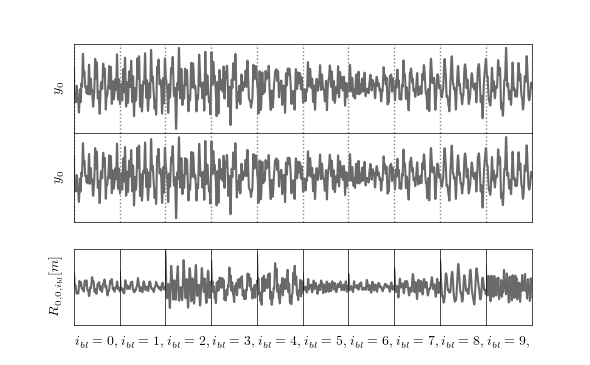

In [58]:
with matplotlib.rc_context(get_pcd('print')):  
    i_r = 0
    i_l = 0

    cutoff = prep_signals.signals.shape[0] - 10*m_lags - 1
    blocks = np.linspace(0,prep_signals.signals.shape[0]-cutoff-m_lags,num=num_blocks+1)

    # First set up the figure, the axis, and the plot element we want to animate
    # fig, (ax1,ax2) = plt.subplots(3,1, sharex=True, sharey=True)

    fig = plt.figure()
    gs = fig.add_gridspec(4, 1, hspace=0.35)
    gs0 = gs[0:2].subgridspec(3,1, hspace=0)
    gs1 = gs[2].subgridspec(1,num_blocks, wspace=0, )

    ax1 = fig.add_subplot(gs0[0,:])
    ax2 = fig.add_subplot(gs0[1,:], sharex=ax1, sharey=ax1)
    axes = [fig.add_subplot(gs1[0,0]),]
    for i in range(1,num_blocks):
        axes.append(fig.add_subplot(gs1[0,i],sharex=axes[0], sharey=axes[0]))



    ax1.plot(prep_signals.signals[:-cutoff-m_lags, i_r], color='dimgrey')
    line, = ax2.plot(prep_signals.signals[:-cutoff-m_lags, i_l], color='dimgrey')

    for t in blocks:
        ax1.axvline(t, lw=1, color='grey', ls='dotted')
    lines = []
    for t in blocks:
        lines.append(ax2.axvline(t, lw=1, color='grey', ls='dotted'))

    corrs = []
    for j, ax in enumerate(axes):
        corrs.append(ax.plot(prep_signals.corr_matrices_bt[j, i_r, i_l,:], color='dimgrey')[0])
        ax.set_xlabel(f'$i_{{bl}}={j},$')
        ax.set_yticks([],[])
        ax.set_xticks([],[])
        ax.set_xlim((0,m_lags))

    ax = axes[0]
    ymin, ymax = ax.get_ylim()
    ymin = min(ymin, -ymax)
    ax.set_ylim((ymin,-ymin))
    ax.set_ylabel('$R_{0,0,i_{bl}}[m]$')

    ax1.set_yticks([],[])
    ax2.set_yticks([],[])
    ax1.set_ylabel(f'$y_{i_r}$')
    ax2.set_ylabel(f'$y_{i_l}$')
    ax1.set_xticks([],[])
    ax2.set_xticks([],[])
    ax1.set_xlim(0,blocks[-1])


